In [1]:
import pandas as pd
import scipy
from collections import namedtuple
import numpy as np
import matplotlib
matplotlib.rc('font',family='Arial')
import matplotlib.pyplot as plt 
import seaborn as sns
import ternary
%config InlineBackend.figure_format='retina'
import matplotlib.ticker as plticker


SMALL_SIZE = 17.77

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 2D Modeling

In [2]:
params_obj=namedtuple('params',['u2','k2','phi_f','phi_r','g2','D','S0'])

def rhs_2d(XS,ts,params):
    A,B,S = XS
    u2,k2,phi_f,phi_r,g2,D,S0 = params[:]    
    dA_dt = (S/(1+S) - D) * A + (phi_f * B - A*phi_r)
    dB_dt = (u2*k2*S/(1+k2*S) - D) * B + (phi_r* A - B*phi_f)
    dS_dt = D*(S0-S) - (A*S/(1+S) + B*g2*u2*k2*S/(1+k2*S))
    
    return np.array([dA_dt,dB_dt,dS_dt])

## Conventional Consortia

In [3]:
ts = np.linspace(0,60,10000)
XS = np.array([4.5,4.5,9])
params_base = params_obj(u2=1.3,k2=1,phi_f=0,phi_r=0,g2=1,D=0.5,S0=9)

res_base = scipy.integrate.odeint(rhs_2d,XS,ts,args=(params_base,))
res_base= pd.DataFrame(res_base,columns=['A','B','Substrate'])

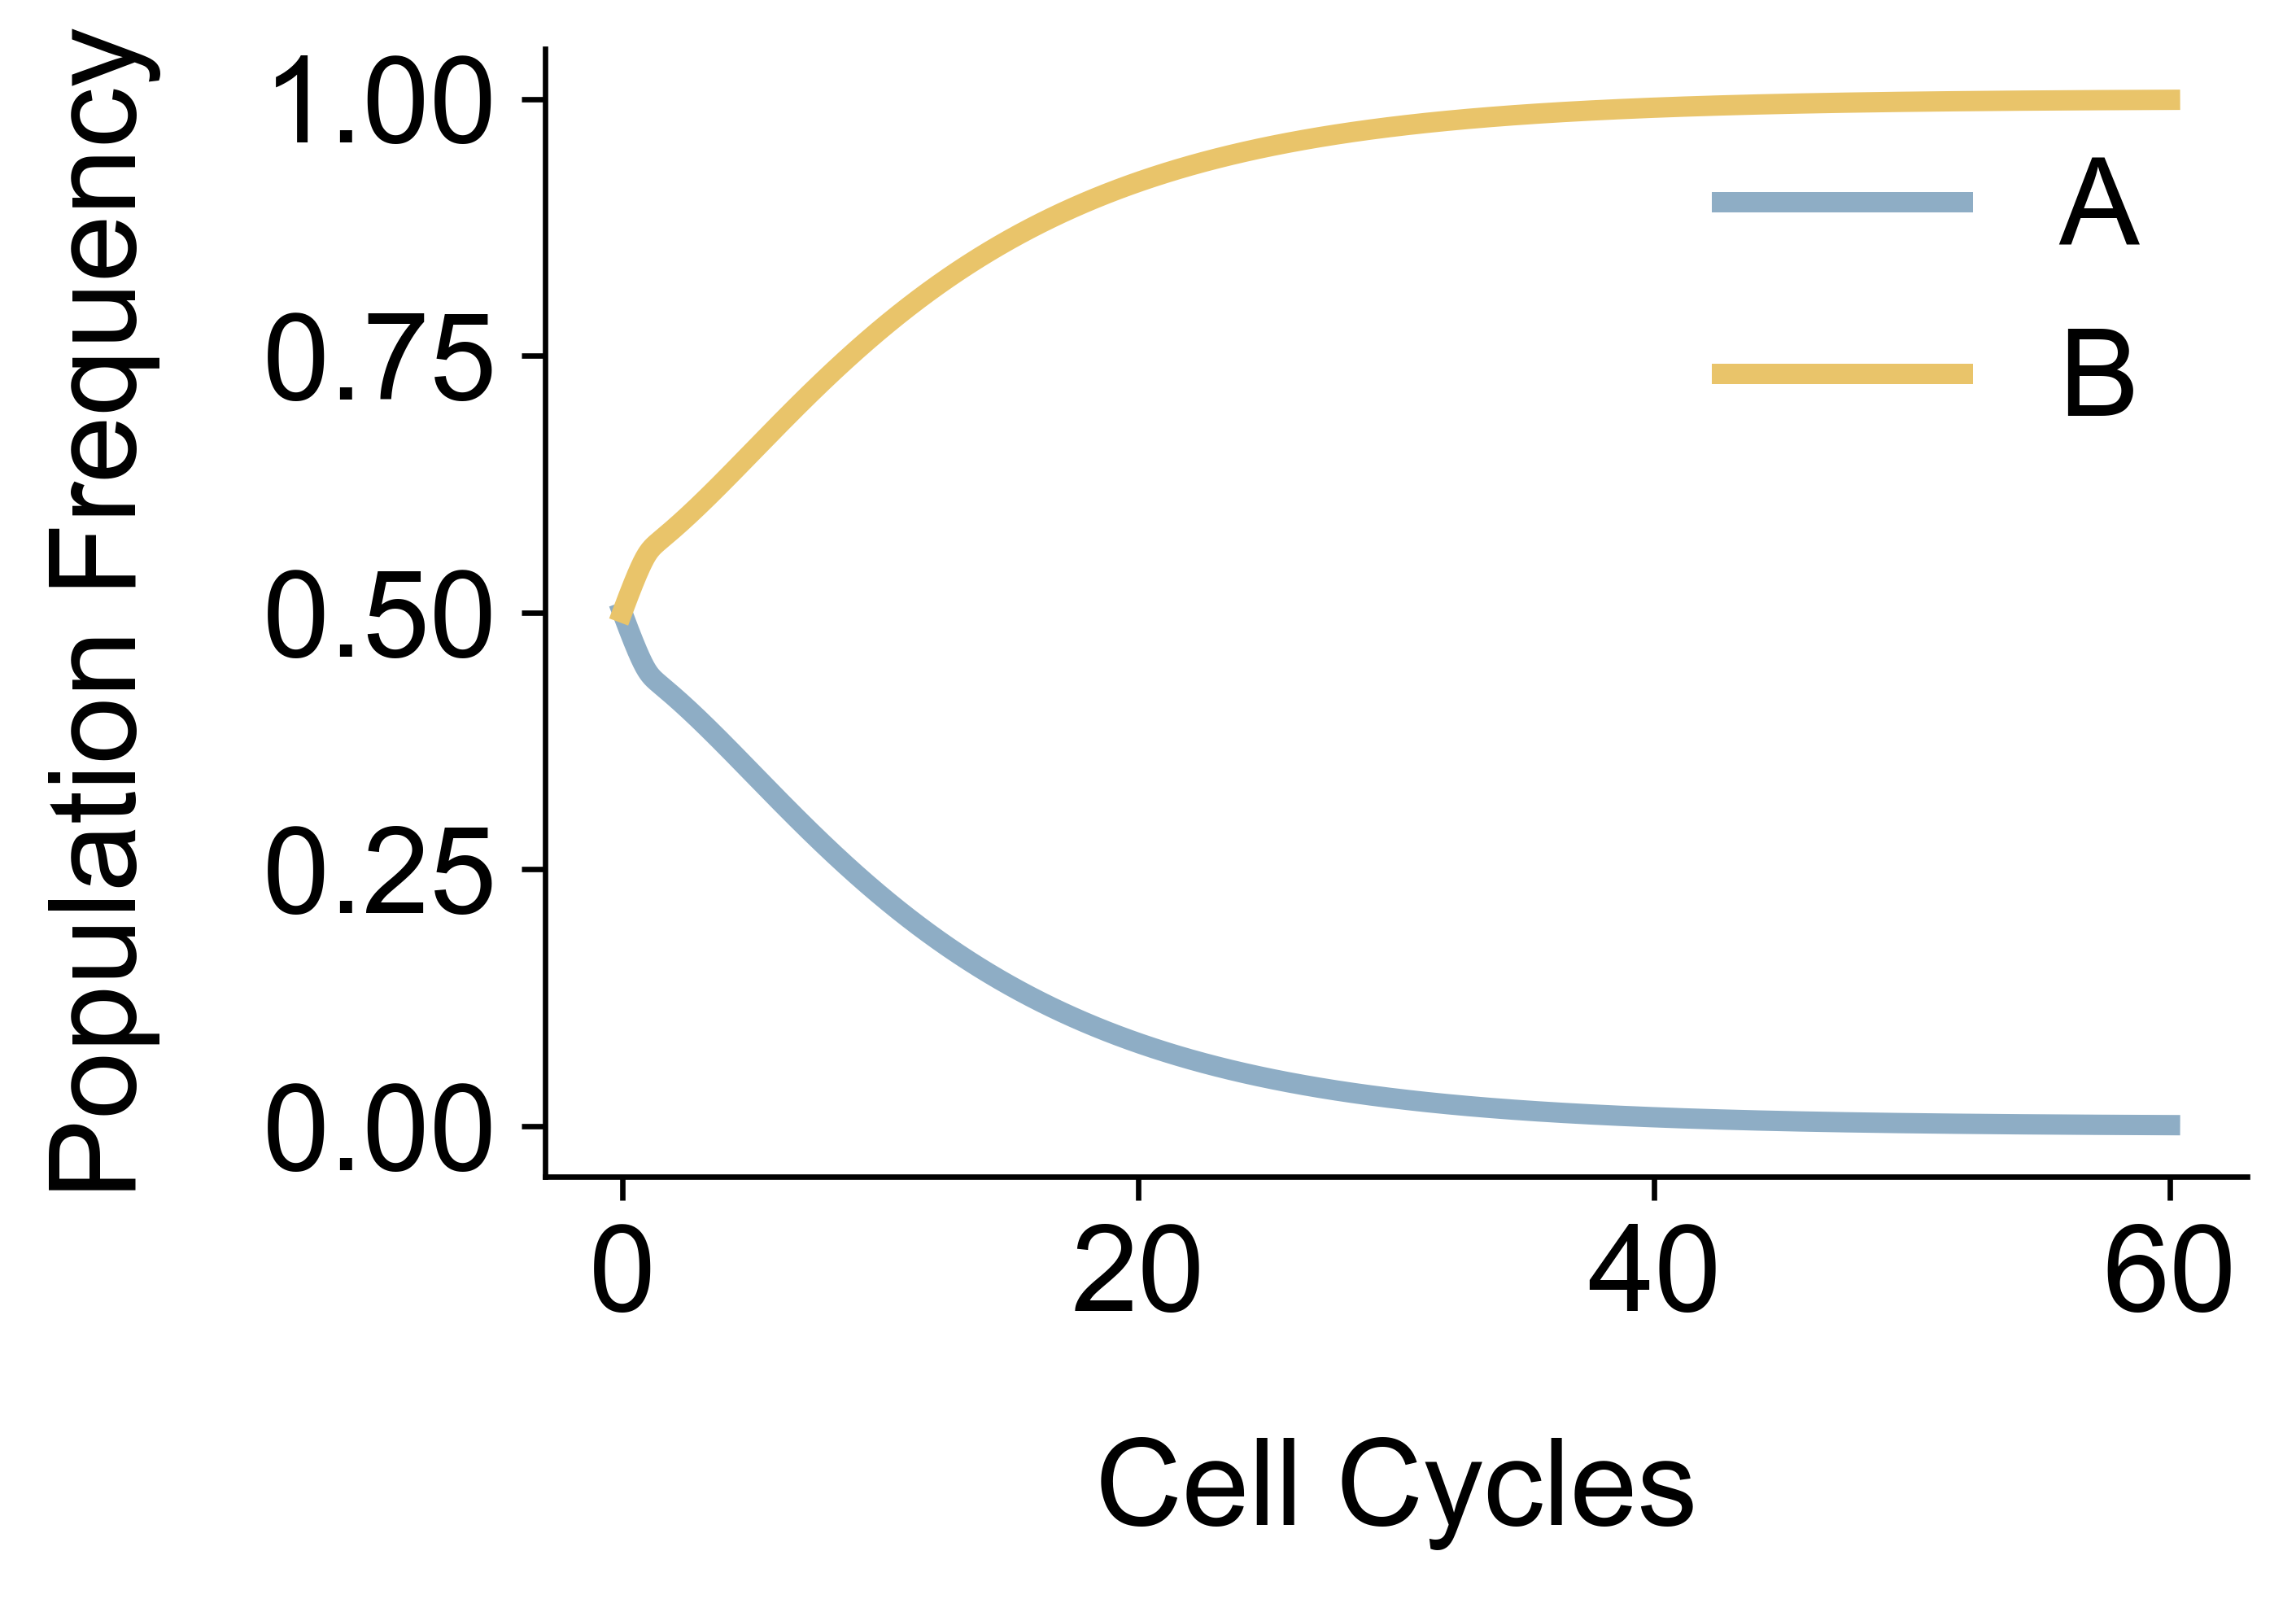

In [4]:
fig,ax = plt.subplots(1,figsize=(4.5,3),dpi=300)
cs = ['#8eadc5','#e9c46a']

for i,name in enumerate(res_base.columns[0:-1]):
    ax.plot(ts,res_base[name]/(res_base['A']+res_base['B']),label=name,lw=3,color=cs[i])


ax.set_xlabel('Cell Cycles',labelpad=15)
ax.set_ylabel('Population Frequency',labelpad=15)
ax.legend(frameon=False)
ax.tick_params(axis='both', which='major',)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
loc = plticker.MultipleLocator(base=0.25)
ax.yaxis.set_major_locator(loc)


## Phase-varying Consortia

In [5]:
ts = np.linspace(0,60,10000)
XS = np.array([4.5,4.5,9])
params_PV = params_obj(u2=1.3,k2=1,phi_f=0.2,phi_r=0.1,g2=1,D=0.5,S0=9)

res_PV = scipy.integrate.odeint(rhs_2d,XS,ts,args=(params_PV,))
res_PV= pd.DataFrame(res_PV,columns=['A','B','Substrate'])

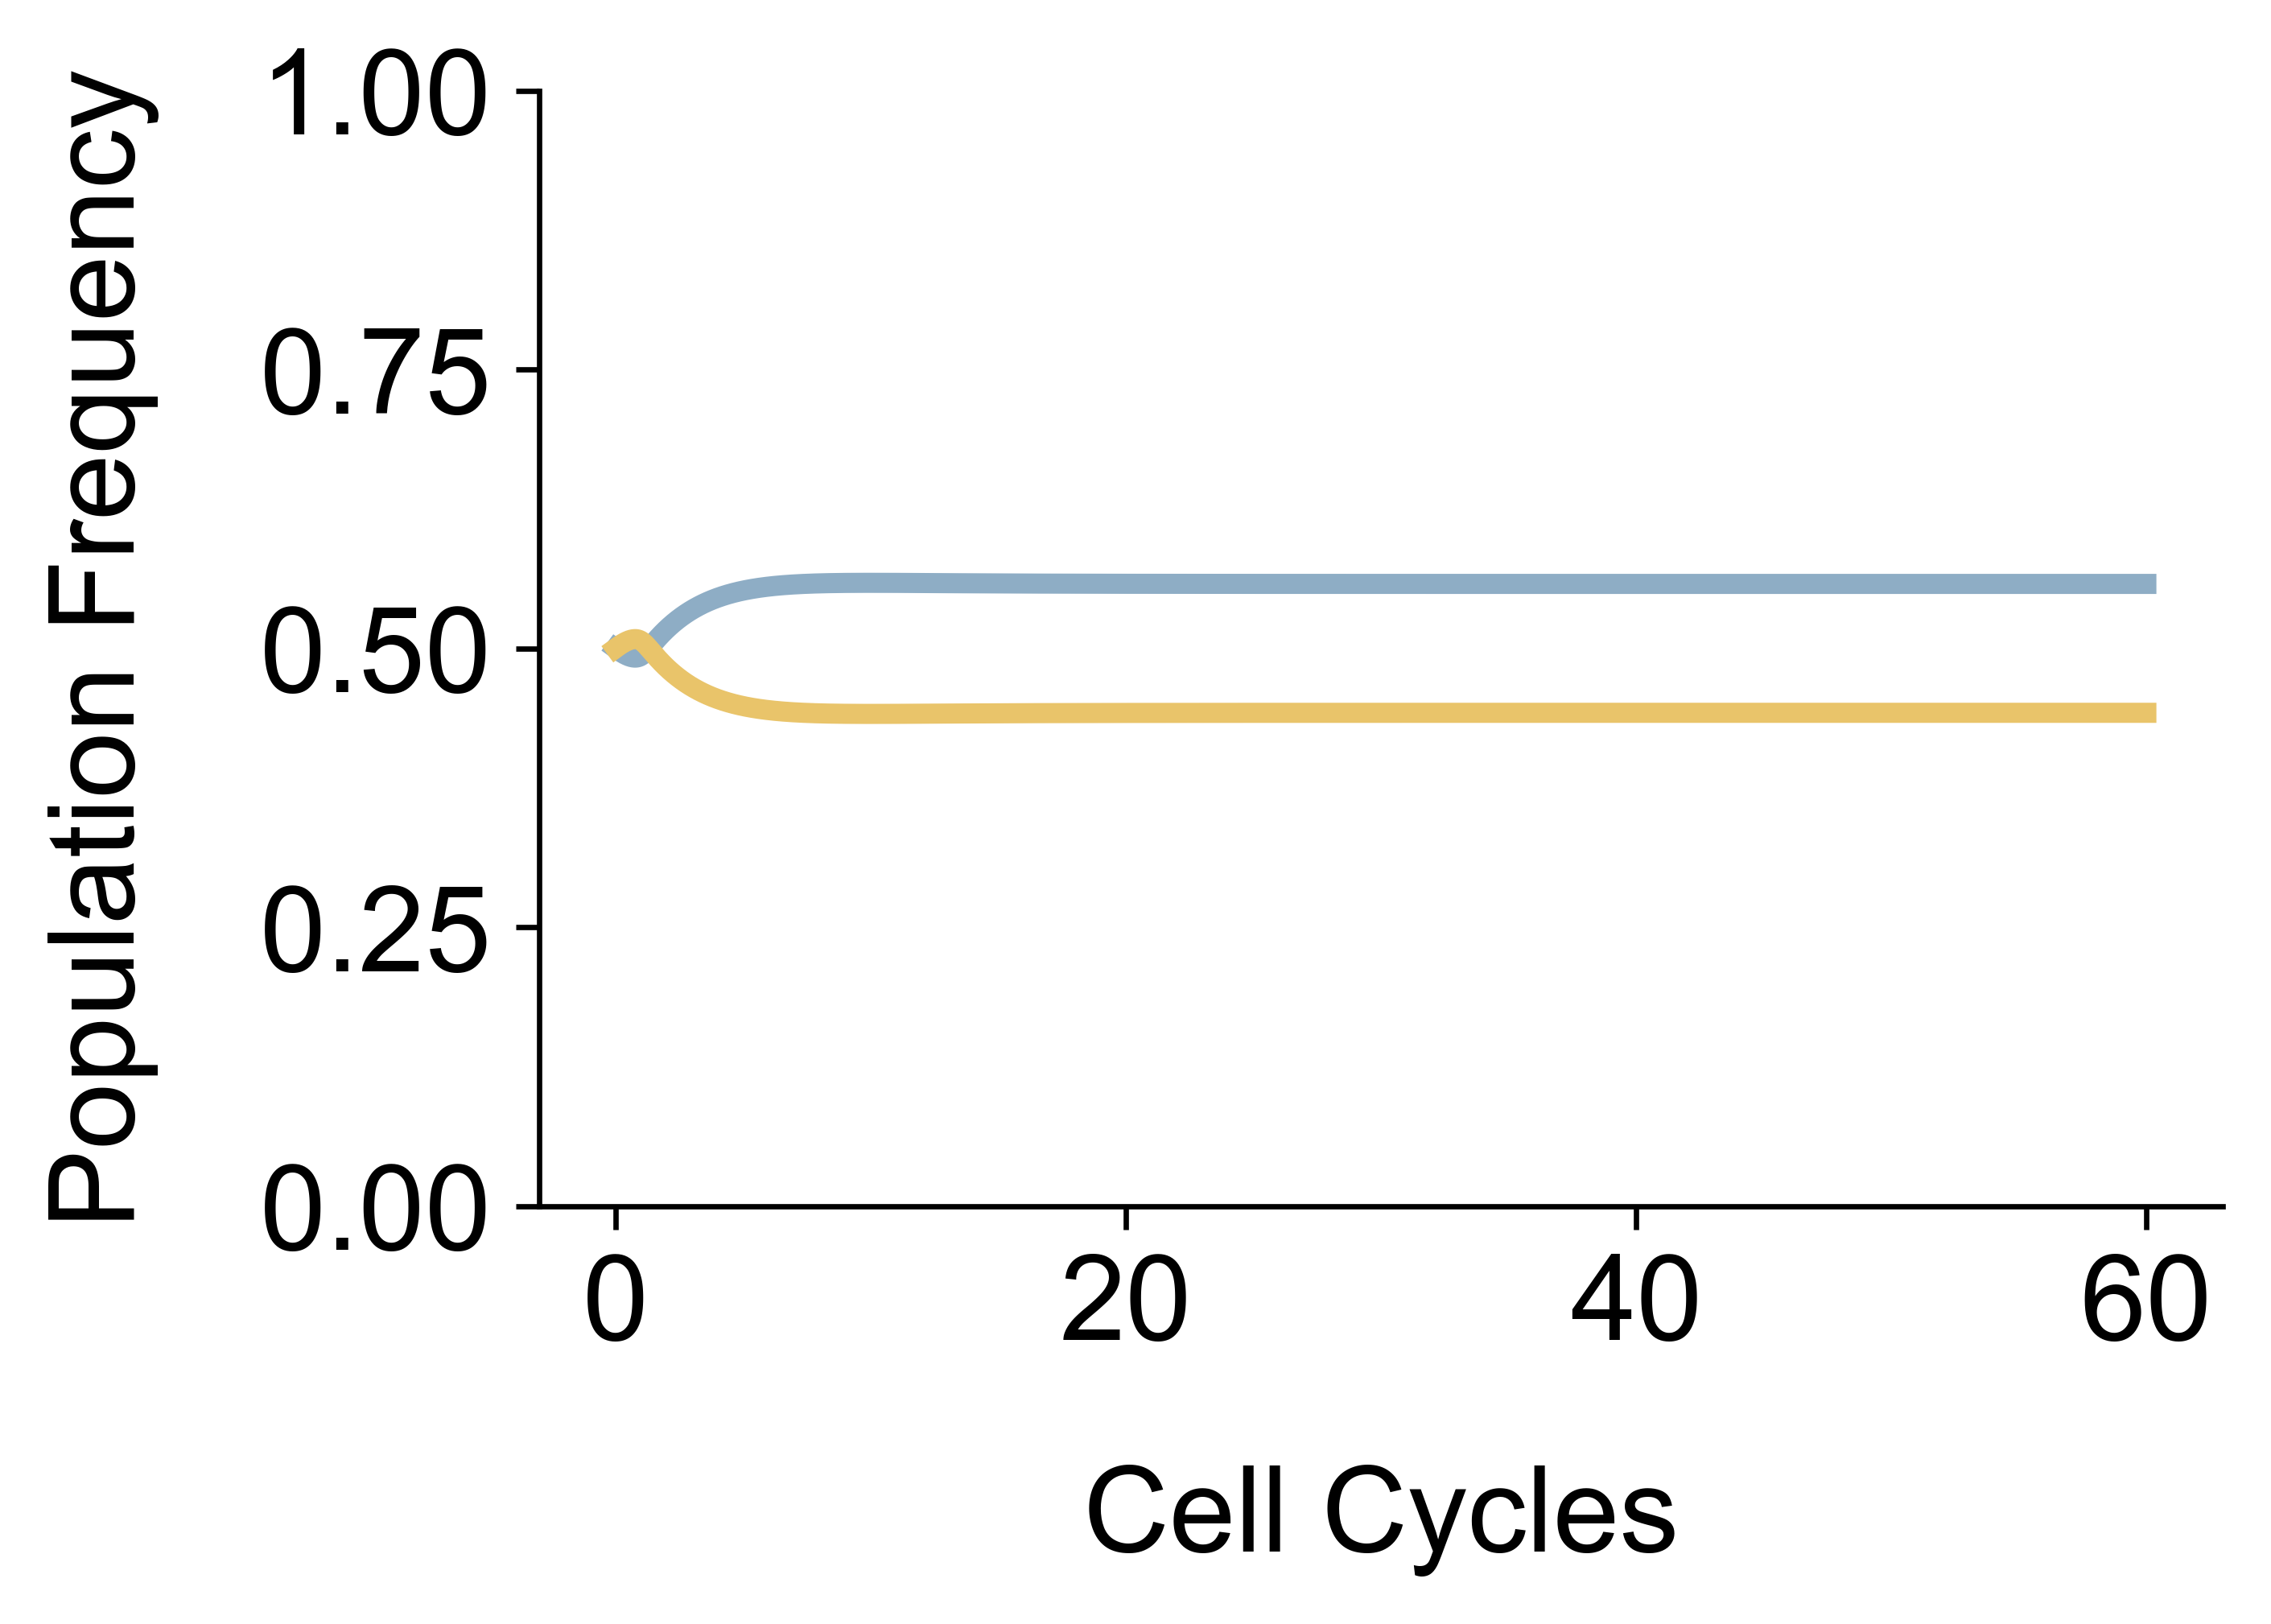

In [6]:
fig,ax = plt.subplots(1,figsize=(4.5,3),dpi=300)
cs = ['#8eadc5','#e9c46a']

for i,name in enumerate(res_PV.columns[0:-1]):
    ax.plot(ts,res_PV[name]/(res_PV['A']+res_PV['B']),label=name,lw=3,color=cs[i])

ax.set_ylim(0,1)
ax.set_xlabel('Cell Cycles',labelpad=15)
ax.set_ylabel('Population Frequency',labelpad=15)
# ax.legend(frameon=False)
ax.tick_params(axis='both', which='major',)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
loc = plticker.MultipleLocator(base=0.25)
ax.yaxis.set_major_locator(loc)


## Composition Control (Supplement)

In [7]:
ts = np.linspace(0,50,1000)
XS = np.array([4.5,4.5,9])

params_list = []
CCs = [(0.33,0.03),(0.28,0.08),(0.275,0.2),(0.11,0.20),(0.05,0.28)]
for sub in CCs:
    params_PV = params_obj(u2=1.3,k2=1,phi_f=sub[0],phi_r=sub[1],g2=1,D=0.5,S0=9)
    params_list.append(params_PV)


res_list = []
for params in params_list:
    res_PV = scipy.integrate.odeint(rhs_2d,XS,ts,args=(params,))
    res_PV= pd.DataFrame(res_PV,columns=['A','B','Substrate'])
    res_list.append(res_PV)
    

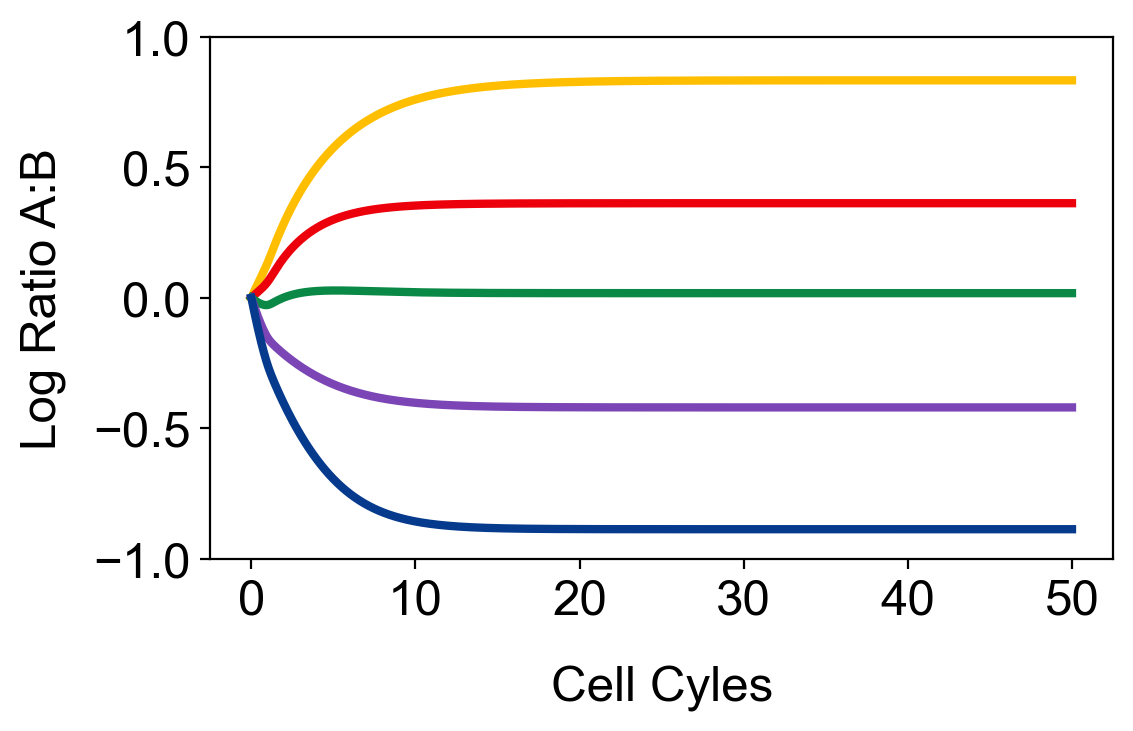

In [8]:
fig,ax = plt.subplots(1,figsize=(6,4))
cs = ['#ffbf00','#ec000b','#098945','#7b45b5','#053a8d']

for i,res in enumerate(res_list):
    ax.plot(ts,np.log10(res['A']/res['B']),lw=3,color=cs[i])

ax.set_ylim(-1,1)
ax.set_xlabel('Cell Cyles',labelpad=15)
ax.set_ylabel('Log Ratio A:B',labelpad=10)
ax.tick_params(axis='both', which='major')
plt.tight_layout()

# 3D Modeling

In [9]:
params_obj=namedtuple('params',['ua','ub','ka','kb','beta1','beta2','beta3','beta4','ga','gb','D','S0'])

def rhs_3d(XS,ts,params):
    Cb,Ca,A,B,S = XS
    ua,ub,ka,kb,beta1,beta2,beta3,beta4,ga,gb,D,S0 = params[:]
    
    dCb_dt = ((S/(1+S)) - D)*Cb + beta4*B + beta2*Ca - Cb*(beta1+beta3)
    dCa_dt = ((S/(1+S)) - D)*Ca + beta4*A + beta1*Cb - Ca*(beta2+beta3)
    dA_dt = ((ua*ka*S/(1+ka*S)) - D)*A + beta1*B + beta3*Ca - A*(beta2+beta4)
    dB_dt = ((ub*kb*S/(1+kb*S)) - D)*B + beta3*Cb + beta2*A - B*(beta1+beta4)
    dS_dt = D*(S0 - S) - ( (S/(1+S))*(Ca + Cb) + (ua*ka*S/(1+ka*S))*(A/ga) + (ub*kb*S/(1+kb*S))*(B/gb) )
    
    return np.array([dCb_dt,dCa_dt,dA_dt,dB_dt,dS_dt])

## Conventional Consortia

In [10]:
ts = np.linspace(0,60,1000)
XS = np.array([2.5,2.5,1.25,1.25,9])
params_base = params_obj(ua=1.1,ub=1.3,ka=1,kb=1,beta1=0,beta2=0,beta3=0,beta4=0,ga=1,gb=1,D=0.5,S0=10)

res_base = scipy.integrate.odeint(rhs_3d,XS,ts,args=(params_base,))
res_base= pd.DataFrame(res_base,columns=['Cb','Ca','A','B','Substrate'])
res_base['C Total'] = res_base['Cb'] + res_base['Ca']
res_base = res_base[['C Total','A','B','Substrate']]
res_base['Cell_total'] = res_base['A']+res_base['B']+res_base['C Total']

## Phase Varying Consortia

In [11]:
ts = np.linspace(0,60,1000)
XS = np.array([2.5,2.5,1.25,1.25,9])
params_PV = params_obj(ua=1.1,ub=1.3,ka=1,kb=1,beta1=0.145,beta2=0.090,beta3=0.1,beta4=0.062,ga=1,gb=1,D=0.5,S0=10)

res_PV = scipy.integrate.odeint(rhs_3d,XS,ts,args=(params_PV,))
res_PV= pd.DataFrame(res_PV,columns=['Cb','Ca','A','B','Substrate'])
res_PV['C Total'] = res_PV['Cb'] + res_PV['Ca']
res_PV = res_PV[['C Total','A','B','Substrate']]
res_PV['Cell_total'] = res_PV['A']+res_PV['B']+res_PV['C Total']

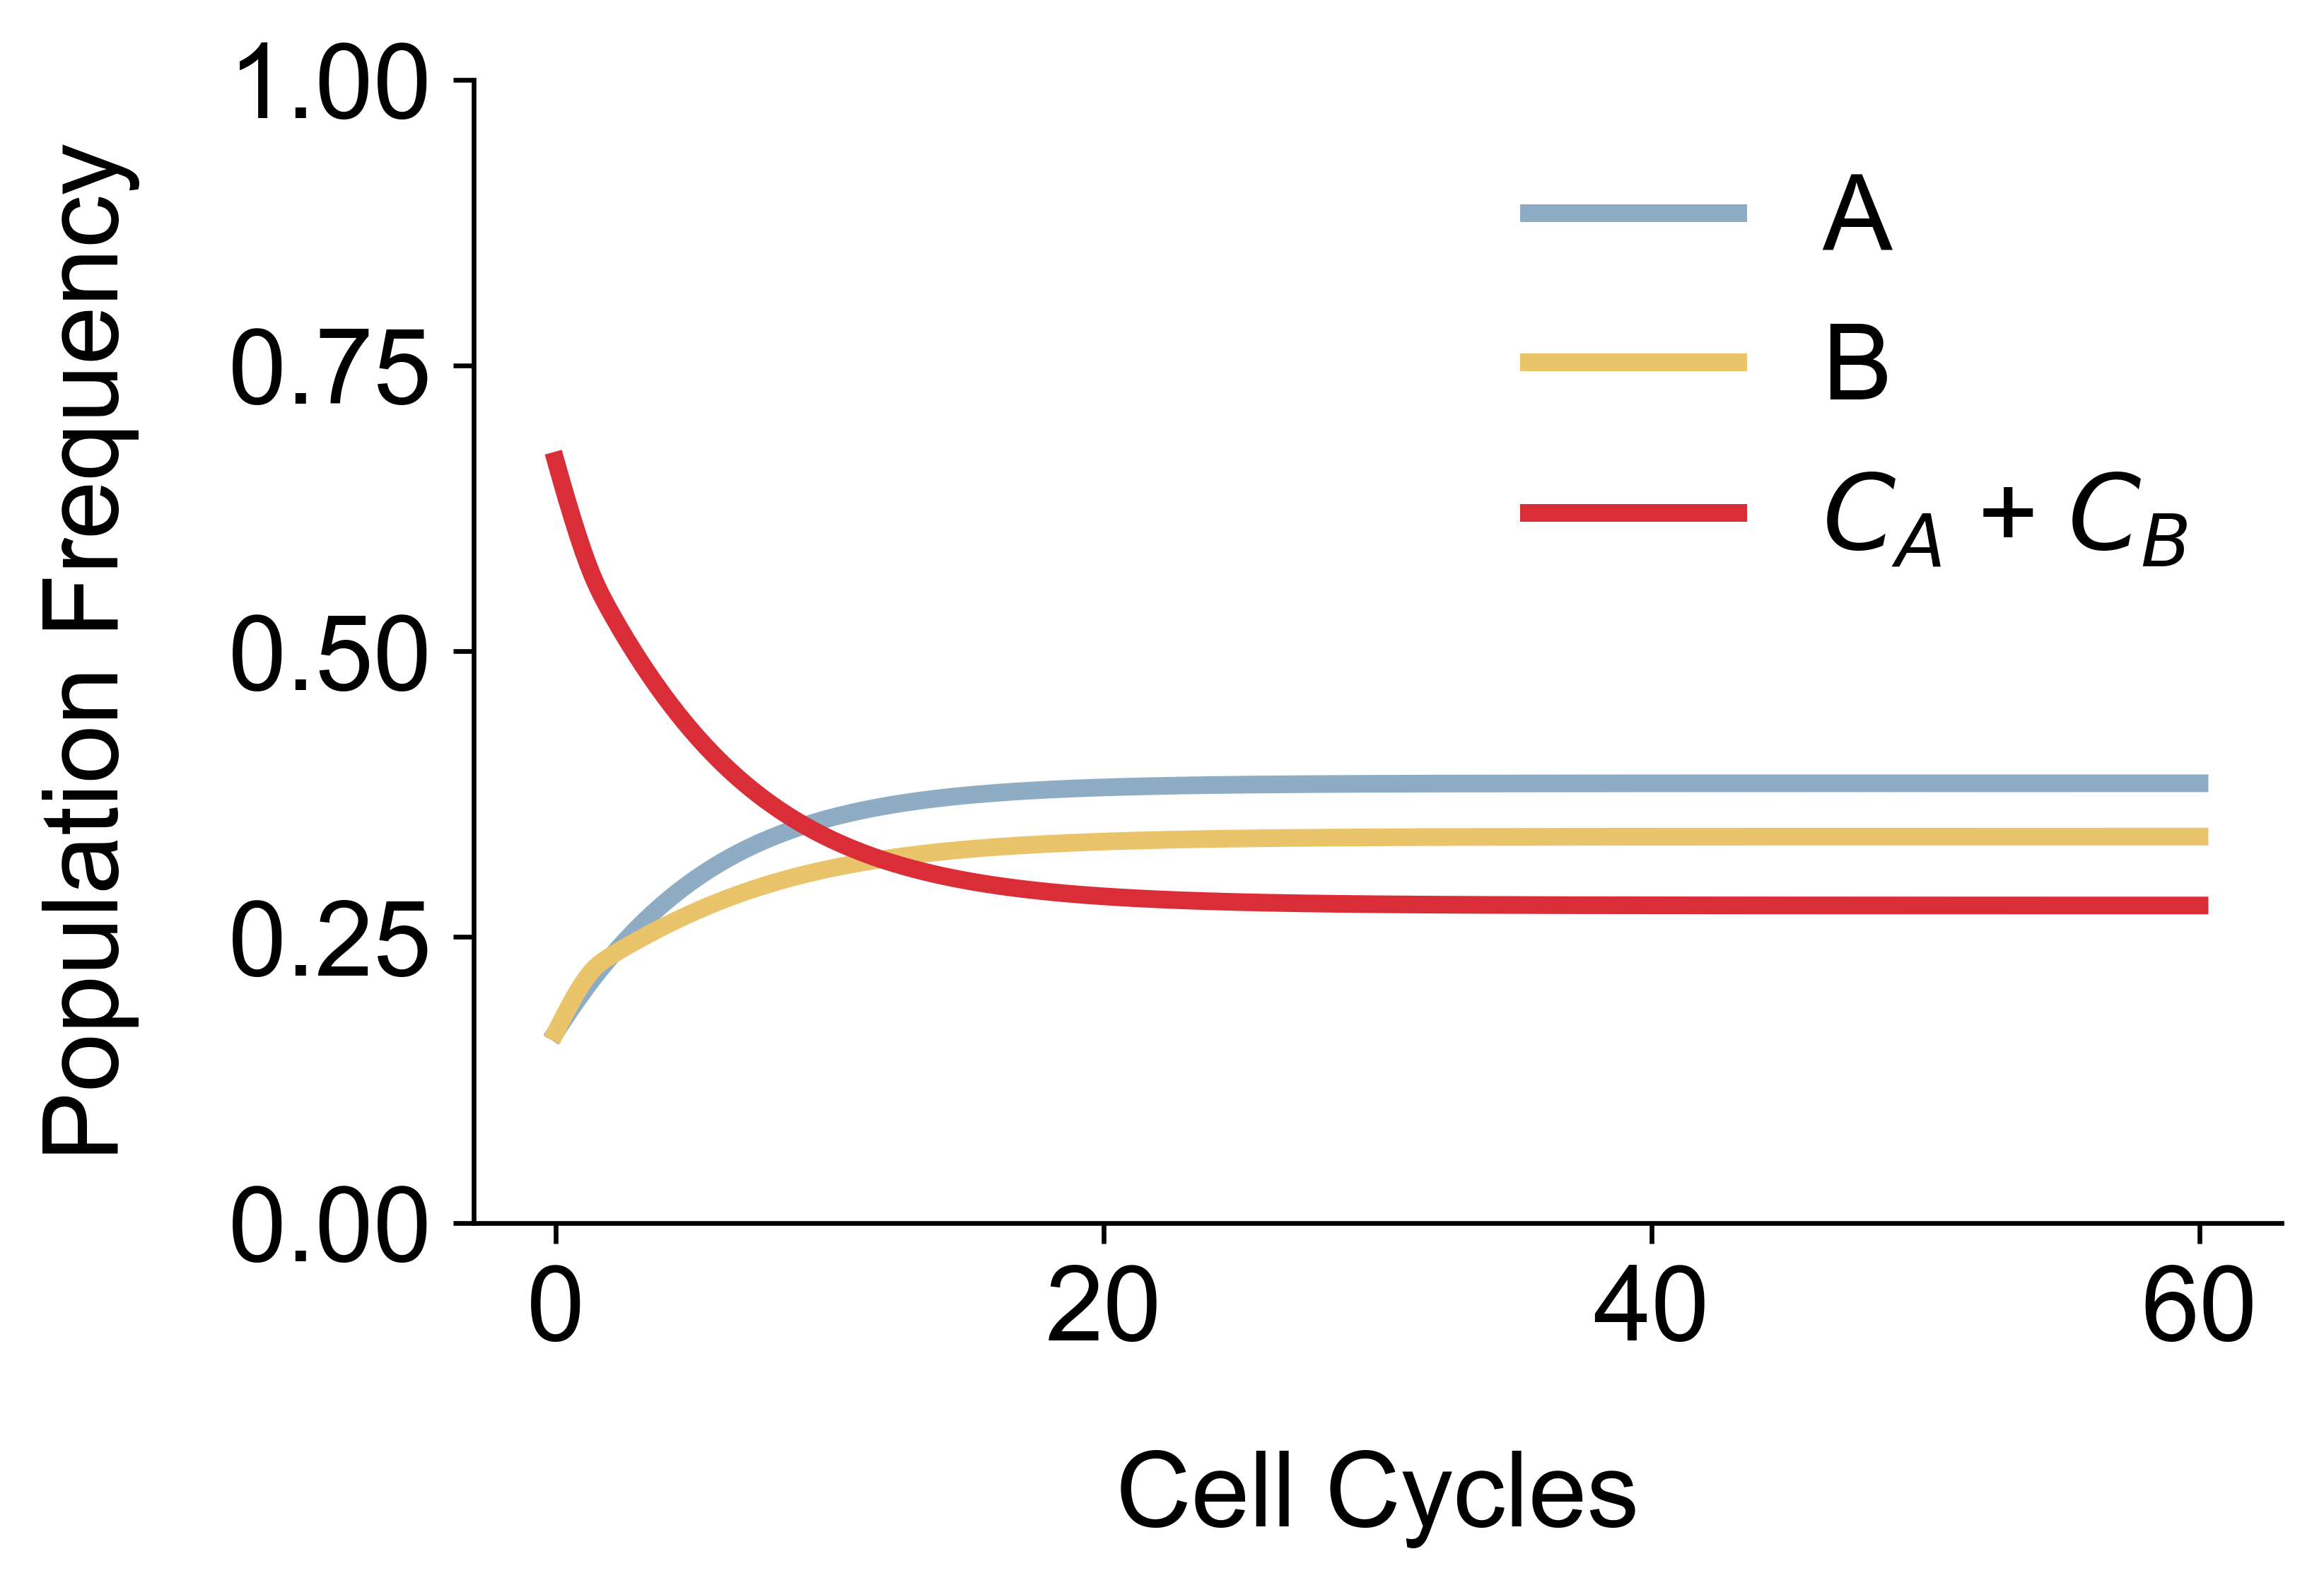

In [12]:
fig,ax = plt.subplots(1,figsize=(5.5,3.5),dpi=300)
cs = ['#8eadc5','#e9c46a','#D92e38']

for i,name in enumerate(['A','B','C Total']):
    if name !='C Total':
        ax.plot(ts,res_PV[name]/(res_PV['Cell_total']),label=name,lw=3,color=cs[i])
    else:
        ax.plot(ts,res_PV[name]/(res_PV['Cell_total']),label='$C_A$ + $C_B$',lw=3,color=cs[i])



ax.set_ylim(0,1)
ax.set_xlabel('Cell Cycles',labelpad=15)
ax.set_ylabel('Population Frequency',labelpad=15)
ax.legend(frameon=False)
ax.tick_params(axis='both', which='major',)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
loc = plticker.MultipleLocator(base=0.25)
ax.yaxis.set_major_locator(loc)


## Composition Tuning 

In [13]:
ts = np.linspace(0,45,1000)
XS = np.array([7,0.5,0.25,0.25,9])
vals = [(0.145,0.090,0.4,0.25),(0.25,0.090,0.2,0.01),(0.1,0.2,0.5,0.1)]

res_list = []
for sub in vals:
    b1,b2,b3,b4 = sub
    params_base = params_obj(ua=1,ub=1.50,ka=1,kb=1,beta1=b1,beta2=b2,beta3=b3,beta4=b4,ga=1,gb=1,D=0.5,S0=9)
    res_base = scipy.integrate.odeint(rhs_3d,XS,ts,args=(params_base,))
    res_base= pd.DataFrame(res_base,columns=['Cb','Ca','A','B','Substrate'])
    res_base['C Total'] = res_base['Cb'] + res_base['Ca']
    res_base = res_base[['C Total','A','B','Substrate']]
    res_base['Cell_total'] = res_base['A']+res_base['B']+res_base['C Total']
    res_list.append(res_base)

# wrangling into ternary diagram compatible data format

formatted_res = []

for res in res_list:
    assembled_list = []
    for t in range(0,len(ts)):
        arr1 = (res['A'].iloc[t]/res['Cell_total'].iloc[t],
           res['B'].iloc[t]/res['Cell_total'].iloc[t],
           res['C Total'].iloc[t]/res['Cell_total'].iloc[t])
        assembled_list.append(100*np.array(arr1))
    formatted_res.append(assembled_list)

/Users/mfk/anaconda3/envs/data_anal/lib/python3.11/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


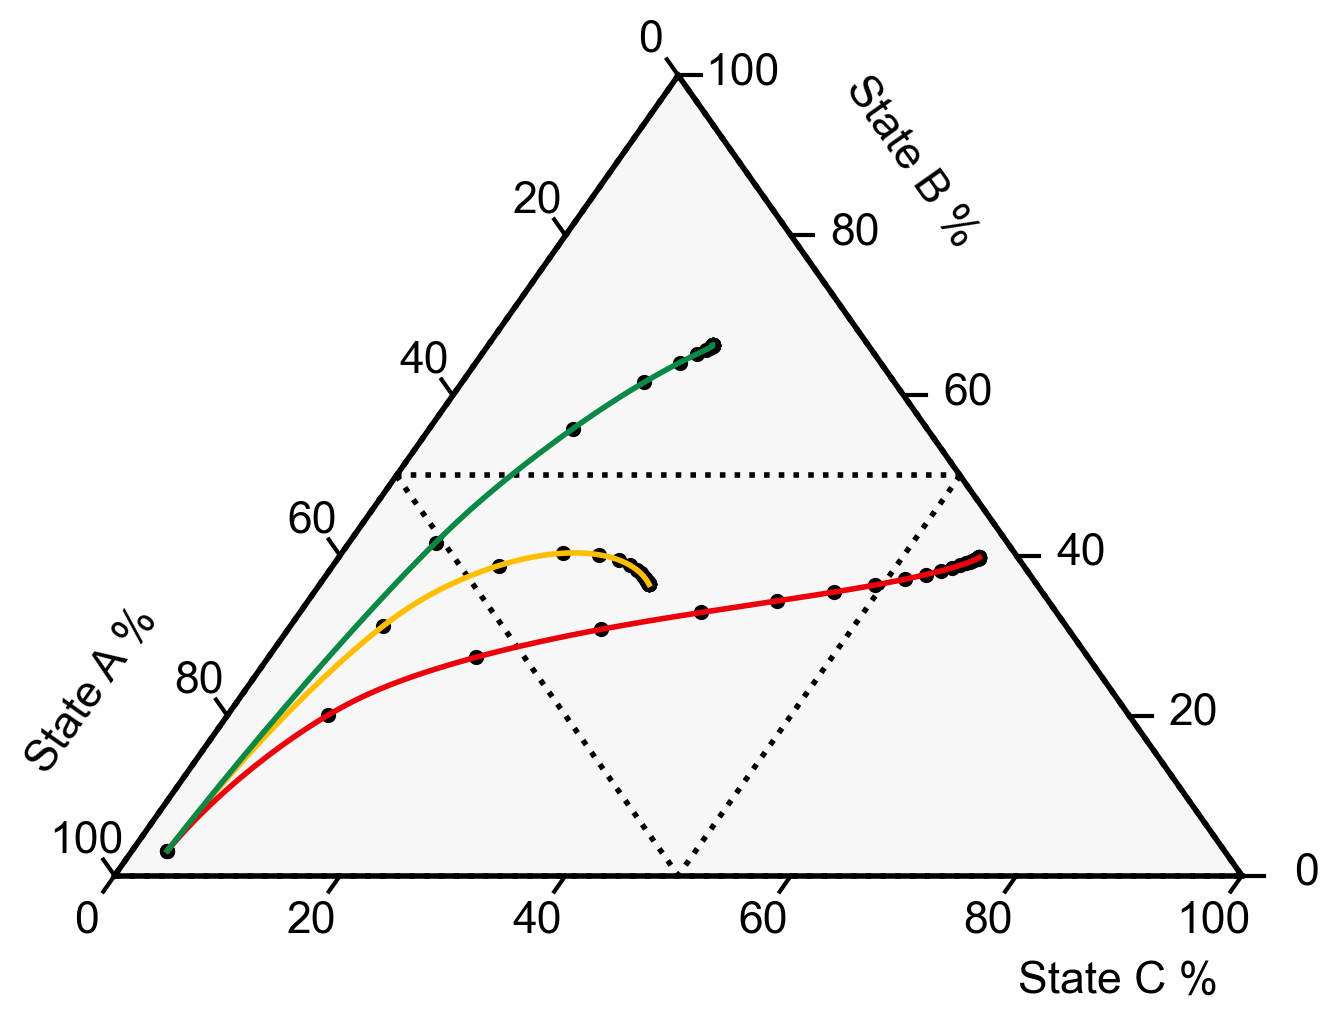

In [14]:
matplotlib.rcParams['figure.figsize'] = (8, 6)

figure, tax = ternary.figure(scale=100)
tax.gridlines(multiple=50, color="black",lw=2)
tax.boundary(linewidth=2)

cs = ['#ffbf00','#ec000b','#098945',]
for i,sub in enumerate(formatted_res):
    tax.plot(sub,lw=2,c=cs[i])
    tax.scatter(sub[::25],c='k',s=20)


tax.ticks(axis='lbr',multiple=20, fontsize=16,offset=0.02)
tax.get_axes().axis('off')
tax.left_axis_label("State A %", fontsize=16, offset=0.14,position=(-0.135,0.34))
tax.right_axis_label("State B %", fontsize=16, offset=0.14,position=(0.18,1))
tax.bottom_axis_label("State C %", fontsize=16, offset=0,position=(0.87,-0.03))